Socila circles: Twitter
This dataset consists of 'circles' (or 'lists') from Twitter. 
Twitter data was crawled from public sources. 
The dataset includes node features (profiles), circles, and ego networks.

First we look at the info of the full datatset and then we view a sample from this dataset so that we can create a subset of it:

In [4]:
import networkx as nx
import random
from networkx.algorithms.distance_measures import diameter

#file_path = "twitter_combined.txt"  
#G = nx.read_edgelist(file_path)


file_path = "twitter/12831.edges"  # Replace with your dataset path
s_G = nx.read_edgelist(file_path) #edges are directed, but we are not treating them like so

ego_node = '12831'
nodes_in_graph = list(s_G.nodes())
# Add edges from the ego node to every other node
for node in nodes_in_graph:
    if node != ego_node:
        s_G.add_edge(ego_node, node)


# Create a subset of the graph (Example: nodes with degree > 50)
#degree_threshold = 50
#subset_nodes = [node for node, degree in dict(G.degree()).items() if degree > degree_threshold]
#s_G = G.subgraph(subset_nodes)

# Find a central node in the subset (e.g., based on degree centrality)
degree_centrality = nx.degree_centrality(s_G)
central_node = max(degree_centrality, key=degree_centrality.get)
print("Central node:", central_node)

# Extract the ego network for the central node
subset_G = nx.ego_graph(s_G, central_node, radius=1)

# Helper: Compute metrics safely with progress logs
def compute_metric(name, func, *args, **kwargs):
    try:
        print(f"Computing {name}...")
        return func(*args, **kwargs)
    except Exception as e:
        print(f"Error computing {name}: {e}")
        return "N/A"

def approximate_diameter(graph, sample_size=100):
    nodes = list(graph.nodes())
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    max_eccentricity = 0
    
    for node in sampled_nodes:
        eccentricity = max(nx.single_source_shortest_path_length(graph, node).values())
        max_eccentricity = max(max_eccentricity, eccentricity)
    
    return max_eccentricity

approx_diameter = approximate_diameter(subset_G)    


# Compute metrics for the subset
subset_metrics = {
    "Nodes": subset_G.number_of_nodes(),
    "Edges": subset_G.number_of_edges(),
    "Nodes in largest WCC": compute_metric("Nodes in largest WCC", lambda g: len(max(nx.connected_components(g), key=len)), subset_G),
    "Edges in largest WCC": compute_metric("Edges in largest WCC", lambda g: subset_G.subgraph(max(nx.connected_components(g), key=len)).number_of_edges(), subset_G),
    "Average clustering coefficient": compute_metric("Average clustering coefficient", nx.average_clustering, subset_G),
    "Number of triangles": compute_metric("Number of triangles", lambda g: sum(nx.triangles(g).values()) // 3, subset_G),
    "Fraction of closed triangles": compute_metric("Fraction of closed triangles", nx.transitivity, subset_G),
    "Approximate diameter": compute_metric("Approximate diameter", approximate_diameter, subset_G),
    }

# Output the subset metrics
print("\nSubset Metrics:")
for key, value in subset_metrics.items():
    print(f"{key}: {value}")


Central node: 12831
Computing Nodes in largest WCC...
Computing Edges in largest WCC...
Computing Average clustering coefficient...
Computing Number of triangles...
Computing Fraction of closed triangles...
Computing Approximate diameter...

Subset Metrics:
Nodes: 237
Edges: 2047
Nodes in largest WCC: 237
Edges in largest WCC: 2047
Average clustering coefficient: 0.5244267275115467
Number of triangles: 6291
Fraction of closed triangles: 0.24920115139831517
Approximate diameter: 2


Central node: 115485051


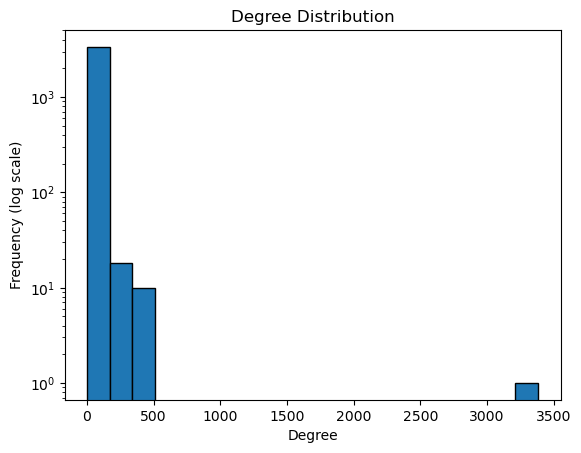

Computing Nodes in largest WCC...
Computing Edges in largest WCC...
Computing Average clustering coefficient...
Computing Number of triangles...
Computing Fraction of closed triangles...

Subset Metrics:
Nodes: 3384
Edges: 35712
Nodes in largest WCC: 3384
Edges in largest WCC: 35712
Average clustering coefficient: 0.671459750332003
Number of triangles: 169475
Fraction of closed triangles: 0.06126811532203584
Approximate diameter: 2
90-percentile effective diameter: 2.0
Number of communities: 15
Modularity score: 0.5133937832213914


In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

# Load graph and preprocess
#file_path = "twitter/12831.edges"  # Replace with your dataset path
file_path = "twitter_combined.txt"
s_G = nx.read_edgelist(file_path)  # Treat edges as undirected
"""
ego_node = '12831'
nodes_in_graph = list(s_G.nodes())
# Add edges from the ego node to every other node
for node in nodes_in_graph:
    if node != ego_node:
        s_G.add_edge(ego_node, node)
"""
# Extract ego network for the central node
degree_centrality = nx.degree_centrality(s_G)
central_node = max(degree_centrality, key=degree_centrality.get)
print("Central node:", central_node)
subset_G = nx.ego_graph(s_G, central_node, radius=1)

# Helper: Compute metrics safely with progress logs
def compute_metric(name, func, *args, **kwargs):
    try:
        print(f"Computing {name}...")
        return func(*args, **kwargs)
    except Exception as e:
        print(f"Error computing {name}: {e}")
        return "N/A"

# Approximate diameter using random sampling
def approximate_diameter(graph, sample_size=100):
    nodes = list(graph.nodes())
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    max_eccentricity = 0
    for node in sampled_nodes:
        eccentricity = max(nx.single_source_shortest_path_length(graph, node).values())
        max_eccentricity = max(max_eccentricity, eccentricity)
    return max_eccentricity

# Calculate 90-percentile effective diameter
def effective_diameter(graph, sample_size=1000):
    if not nx.is_connected(graph):
        print("Graph is not connected; calculating effective diameter on largest connected component.")
        graph = graph.subgraph(max(nx.connected_components(graph), key=len))
    nodes = list(graph.nodes())
    sampled_pairs = random.sample([(u, v) for u in nodes for v in nodes if u != v], min(sample_size, len(nodes) * (len(nodes) - 1)))
    shortest_paths = []
    for source, target in sampled_pairs:
        try:
            shortest_paths.append(nx.shortest_path_length(graph, source, target))
        except nx.NetworkXNoPath:
            continue
    return np.percentile(shortest_paths, 90)

# Compute degree distribution
def compute_degree_distribution(graph):
    degree_sequence = [degree for _, degree in graph.degree()]
    plt.hist(degree_sequence, bins=20, edgecolor="black", log=True)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency (log scale)")
    plt.savefig("ScreenShots/degree_distribution.png", dpi=300)
    plt.show()
    return degree_sequence

# Compute modularity and communities
def compute_modularity(graph):
    communities = nx.community.louvain_communities(graph, seed=42)
    modularity_score = nx.community.modularity(graph, communities)
    return len(communities), modularity_score

# Compute metrics for the subset
degree_distribution = compute_degree_distribution(subset_G)
approx_diameter = approximate_diameter(subset_G)
effective_diam = effective_diameter(subset_G)
num_communities, modularity_score = compute_modularity(subset_G)

subset_metrics = {
    "Nodes": subset_G.number_of_nodes(),
    "Edges": subset_G.number_of_edges(),
    "Nodes in largest WCC": compute_metric(
        "Nodes in largest WCC", lambda g: len(max(nx.connected_components(g), key=len)), subset_G
    ),
    "Edges in largest WCC": compute_metric(
        "Edges in largest WCC", lambda g: subset_G.subgraph(max(nx.connected_components(g), key=len)).number_of_edges(), subset_G
    ),
    "Average clustering coefficient": compute_metric("Average clustering coefficient", nx.average_clustering, subset_G),
    "Number of triangles": compute_metric(
        "Number of triangles", lambda g: sum(nx.triangles(g).values()) // 3, subset_G
    ),
    "Fraction of closed triangles": compute_metric("Fraction of closed triangles", nx.transitivity, subset_G),
    "Approximate diameter": approx_diameter,
    "90-percentile effective diameter": effective_diam,
    "Number of communities": num_communities,
    "Modularity score": modularity_score,
}

# Output the subset metrics
print("\nSubset Metrics:")
for key, value in subset_metrics.items():
    print(f"{key}: {value}")

In [45]:
import networkx as nx
from sklearn.metrics import balanced_accuracy_score, f1_score

# Step 2: Generate dummy ground truth and predictions (example)
def generate_labels_and_predictions(graph):
    # Simulating ground truth and predictions for nodes
    ground_truth = {node: 1 if graph.degree[node] > 60 else 0 for node in graph.nodes()}
    predictions = {node: 1 if graph.degree[node] > 55 else 0 for node in graph.nodes()}
    return ground_truth, predictions

# Step 3: Calculate BER and F1 Score
def calculate_metrics(ground_truth, predictions):
    y_true = list(ground_truth.values())  # Ground truth labels
    y_pred = list(predictions.values())  # Model predictions
    
    # Compute metrics
    ber = 1 - balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Balanced Error Rate (BER): {ber}")
    print(f"F1 Score: {f1}")
    return ber, f1

# Main function to execute the analysis
def main():
    
    # Generate ground truth and predictions
    ground_truth, predictions = generate_labels_and_predictions(subset_G)

    # Calculate metrics
    calculate_metrics(ground_truth, predictions)

if __name__ == "__main__":
    main()

Balanced Error Rate (BER): 0.005455112219451386
F1 Score: 0.9095607235142119


We now detect communities with the louvain algorithm and analyse them:

Total number of communities: 16
Sizes of communities: [267, 66, 220, 282, 86, 166, 53, 609, 17, 129, 440, 345, 90, 160, 397, 57]


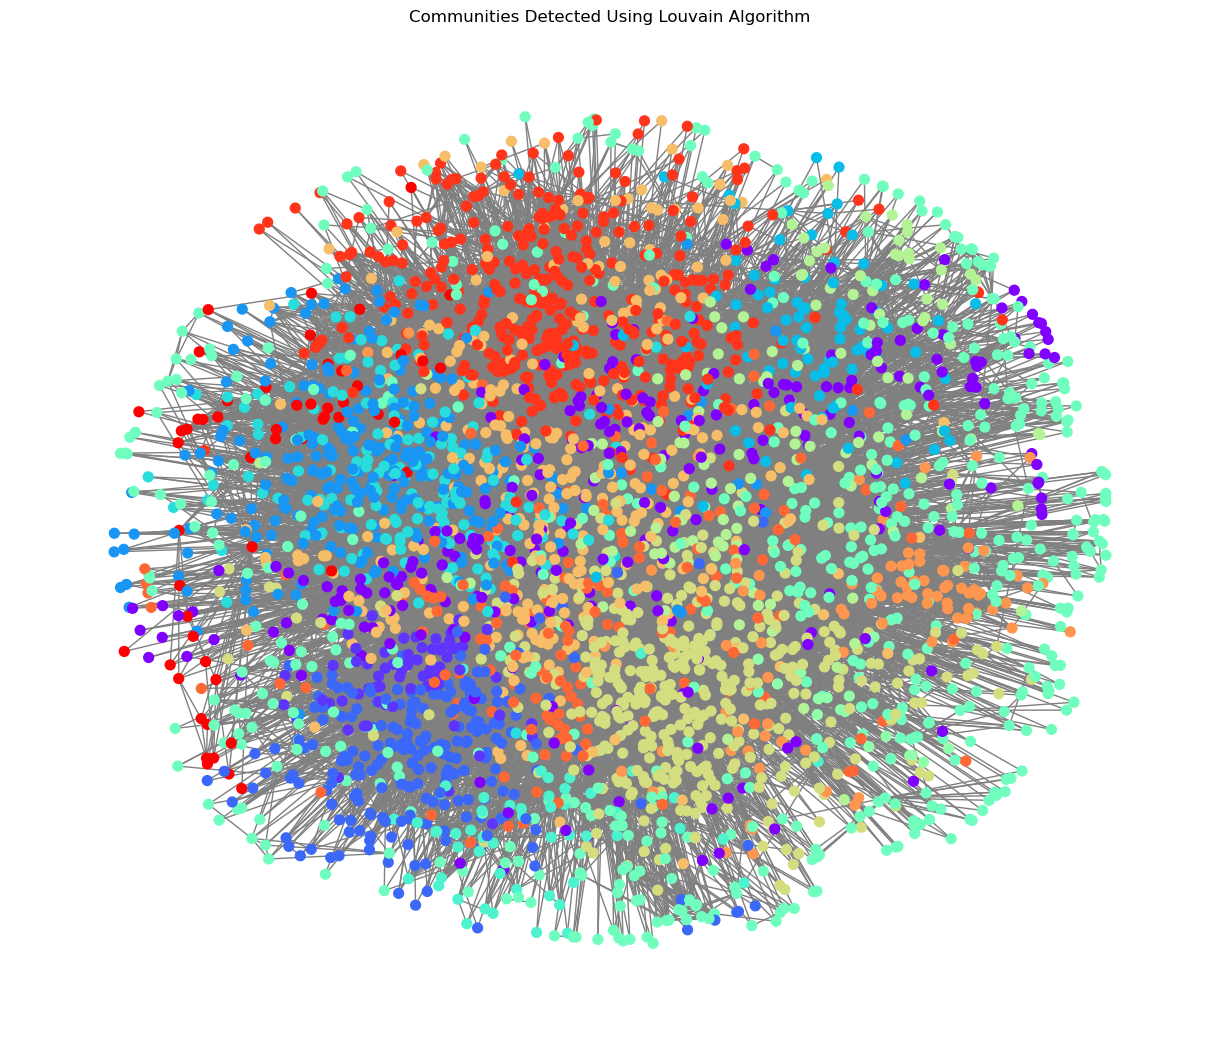

Number of internal edges in each community: [1590, 478, 1192, 2175, 745, 1365, 195, 1898, 64, 421, 4259, 2390, 556, 1013, 3366, 336]
Top central nodes in Community 0: [('972651', 0.05291161690806977), ('23544596', 0.036653857522908666), ('13348', 0.035767070647354425), ('20', 0.0325155187703222), ('13', 0.030150753768844223)]
Top central nodes in Community 1: [('154701532', 0.026012415016257763), ('29844579', 0.012710611882944133), ('79386459', 0.012119420632574639), ('58386073', 0.011528229382205145), ('7729542', 0.011232633757020397)]
Top central nodes in Community 2: [('79797834', 0.1037540644398463), ('22872643', 0.02955956251847473), ('87525002', 0.024830032515518772), ('18069824', 0.02069169376293231), ('13058232', 0.020100502512562814)]
Top central nodes in Community 3: [('1183041', 0.12740171445462609), ('10350', 0.07212533254507834), ('3829151', 0.06591782441619864), ('657863', 0.0650310375406444), ('610533', 0.034289092521430684)]
Top central nodes in Community 4: [('12998413

In [46]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import matplotlib.pyplot as plt

# Step 2: Run the Louvain Community Detection Algorithm
# Parameters: weight='weight', resolution=1, threshold=1e-07, max_level=None
communities = louvain_communities(subset_G, resolution=1, threshold=1e-07, seed=42)

# Number of communities
print(f"Total number of communities: {len(communities)}")

# Size of each community
community_sizes = [len(community) for community in communities]
print("Sizes of communities:", community_sizes)


# Step 3: Visualize the Communities
def visualize_communities(graph, communities):
    # Assign colors to nodes based on their community
    community_map = {node: idx for idx, community in enumerate(communities) for node in community}
    node_colors = [community_map[node] for node in graph.nodes()]
    
    # Generate layout for better visualization
    pos = nx.spring_layout(graph)

    # Draw the graph
    plt.figure(figsize=(12, 10))
    nx.draw(
        graph, pos,
        node_color=node_colors,
        with_labels=False,
        cmap=plt.cm.rainbow,
        node_size=50,
        edge_color="gray"
    )
    plt.title("Communities Detected Using Louvain Algorithm")
    
    # Save the plot
    plt.savefig("ScreenShots/louvain_communities.png", format="png", dpi=300)  # Save as PNG with high resolution
    plt.show()

# Call visualization
visualize_communities(subset_G, communities)


internal_edges = [subset_G.subgraph(community).number_of_edges() for community in communities]
print("Number of internal edges in each community:", internal_edges)

degree_centrality = nx.degree_centrality(subset_G)
for idx, community in enumerate(communities):
    centrality = {node: degree_centrality[node] for node in community}
    sorted_centrality = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
    print(f"Top central nodes in Community {idx}:", sorted_centrality[:5])

for idx, community in enumerate(communities):
    print(f"Community {idx}:")
    print(f"Size: {len(community)}")
    print(f"Internal Edges: {internal_edges[idx]}")
    print(f"Top central nodes: {sorted_centrality[:5]}")


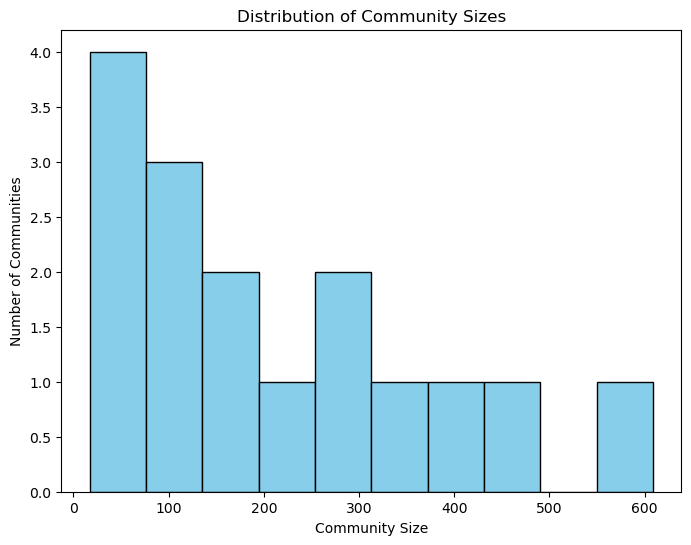

In [47]:
import matplotlib.pyplot as plt

# Plot community size distribution
plt.figure(figsize=(8, 6))
plt.hist(community_sizes, bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Community Size")
plt.ylabel("Number of Communities")
plt.title("Distribution of Community Sizes")
plt.show()


In [48]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(subset_G)

# Identify top nodes in each community
for idx, community in enumerate(communities):
    top_node = max(community, key=lambda node: degree_centrality[node])
    print(f"Community {idx + 1}: Top node {top_node} (Degree Centrality: {degree_centrality[top_node]:.3f})")


Community 1: Top node 972651 (Degree Centrality: 0.053)
Community 2: Top node 154701532 (Degree Centrality: 0.026)
Community 3: Top node 79797834 (Degree Centrality: 0.104)
Community 4: Top node 1183041 (Degree Centrality: 0.127)
Community 5: Top node 129984134 (Degree Centrality: 0.020)
Community 6: Top node 22461427 (Degree Centrality: 0.108)
Community 7: Top node 68732646 (Degree Centrality: 0.022)
Community 8: Top node 115485051 (Degree Centrality: 1.000)
Community 9: Top node 73443014 (Degree Centrality: 0.009)
Community 10: Top node 259379883 (Degree Centrality: 0.058)
Community 11: Top node 15485441 (Degree Centrality: 0.141)
Community 12: Top node 90420314 (Degree Centrality: 0.145)
Community 13: Top node 21447363 (Degree Centrality: 0.020)
Community 14: Top node 15846407 (Degree Centrality: 0.067)
Community 15: Top node 3359851 (Degree Centrality: 0.078)
Community 16: Top node 12771872 (Degree Centrality: 0.015)


In [49]:
# Intra-community edges
def intra_community_edges(graph, community):
    return graph.subgraph(community).number_of_edges()

# Inter-community edges
def inter_community_edges(graph, community1, community2):
    return len([
        (u, v) for u in community1 for v in community2 if graph.has_edge(u, v)
    ])

# Compute edge metrics
for idx, community in enumerate(communities):
    intra_edges = intra_community_edges(subset_G, community)
    print(f"Community {idx + 1}: {len(community)} nodes, {intra_edges} intra-community edges")


Community 1: 267 nodes, 1590 intra-community edges
Community 2: 66 nodes, 478 intra-community edges
Community 3: 220 nodes, 1192 intra-community edges
Community 4: 282 nodes, 2175 intra-community edges
Community 5: 86 nodes, 745 intra-community edges
Community 6: 166 nodes, 1365 intra-community edges
Community 7: 53 nodes, 195 intra-community edges
Community 8: 609 nodes, 1898 intra-community edges
Community 9: 17 nodes, 64 intra-community edges
Community 10: 129 nodes, 421 intra-community edges
Community 11: 440 nodes, 4259 intra-community edges
Community 12: 345 nodes, 2390 intra-community edges
Community 13: 90 nodes, 556 intra-community edges
Community 14: 160 nodes, 1013 intra-community edges
Community 15: 397 nodes, 3366 intra-community edges
Community 16: 57 nodes, 336 intra-community edges


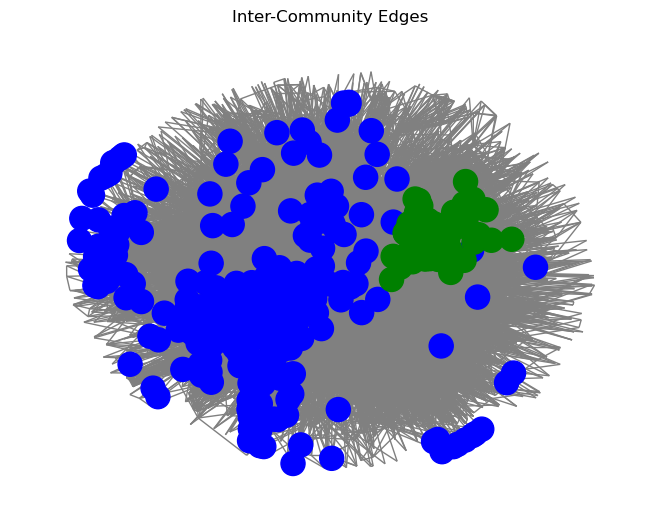

In [50]:
def visualize_inter_community_edges(graph, comm1, comm2):
    pos = nx.spring_layout(graph)
    nx.draw(
        graph, pos,
        nodelist=list(comm1) + list(comm2),
        node_color=["blue"] * len(comm1) + ["green"] * len(comm2),
        with_labels=False,
        edge_color="gray"
    )
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=[(u, v) for u in comm1 for v in comm2 if graph.has_edge(u, v)],
        edge_color="red"
    )
    plt.title("Inter-Community Edges")
    plt.show()

# Visualize edges between Community 1 and Community 2
visualize_inter_community_edges(subset_G, communities[0], communities[1])


In [51]:
from networkx.algorithms.community.quality import modularity

# Compute modularity
modularity_score = modularity(subset_G, communities)
print(f"Modularity of the partition: {modularity_score:.3f}")

for idx, community in enumerate(communities):
    subgraph = subset_G.subgraph(community)
    density = nx.density(subgraph)
    print(f"Community {idx + 1}: Density = {density:.3f}")


Modularity of the partition: 0.512
Community 1: Density = 0.045
Community 2: Density = 0.223
Community 3: Density = 0.049
Community 4: Density = 0.055
Community 5: Density = 0.204
Community 6: Density = 0.100
Community 7: Density = 0.142
Community 8: Density = 0.010
Community 9: Density = 0.471
Community 10: Density = 0.051
Community 11: Density = 0.044
Community 12: Density = 0.040
Community 13: Density = 0.139
Community 14: Density = 0.080
Community 15: Density = 0.043
Community 16: Density = 0.211


In [54]:
import pandas as pd

# Load features
feat_file = "twitter/12831.feat"
features_df = pd.read_csv(feat_file, sep='\\s+', header=None)

# Separate node IDs and feature vectors
node_ids = features_df.iloc[:, 0]  # First column: node IDs
feature_vectors = features_df.iloc[:, 1:]  # Remaining columns: binary features

node_feature_dict = features_df.set_index(0).T.to_dict('list')

# Check the size of the ego features
ego_feat_file = "twitter/12831.egofeat"
ego_features = pd.read_csv(ego_feat_file, sep='\\s+', header=None).iloc[0].tolist()
print(f"Ego Features Size: {len(ego_features)}")

# Add ego features to the dictionary (optional)
node_feature_dict[12831] = ego_features



Ego Features Size: 1364


In [55]:
community_features = []


    
for idx, community in enumerate(communities):
    # Get feature vectors for all nodes in the community
    community_nodes = [int(node) for node in community if int(node) in node_feature_dict]
    community_feats = [node_feature_dict[node] for node in community_nodes]
    
    # Aggregate features (e.g., sum or average)
    if community_feats:
        aggregated_features = pd.DataFrame(community_feats).mean(axis=0).tolist()  # Average features
    else:
        aggregated_features = []
    
    community_features.append({
        "Community": idx,
        "Nodes": len(community_nodes),
        "Aggregated Features": aggregated_features
    })





In [56]:
import pandas as pd
import matplotlib.pyplot as plt

featnames_file = "twitter/12831.featnames"

# Open the file with UTF-8 encoding
with open(featnames_file, "r", encoding="utf-8") as f:
    feature_names = [line.strip() for line in f]

# Ensure the number of feature names matches the feature vector length
print(f"Total Features: {len(feature_names)}")

# Assuming `community_features` is already computed
community_features = []


for idx, community in enumerate(communities):
    # Get feature vectors for all nodes in the community
    community_nodes = [int(node) for node in community]
    community_feats = [node_feature_dict[node] for node in community_nodes]
    
    # Aggregate features (e.g., sum or average)
    if community_feats:
        aggregated_features = pd.DataFrame(community_feats).mean(axis=0).tolist()  # Average features
    else:
        aggregated_features = []
    
    # Map aggregated features to feature names
    feature_summary = dict(zip(feature_names, aggregated_features)) if aggregated_features else {}

    community_features.append({
        "Community": idx,
        "Nodes": len(community_nodes),
        "Feature Summary": feature_summary
    })

# Print summary of community features with feature names
for cf in community_features:
    print(f"Community {cf['Community']}:")
    print(f"  Number of Nodes: {cf['Nodes']}")


def plot_feature_comparison(community_features, top_k=10, output_file="feature_comparison.png"):
    # Extract features for visualization as a DataFrame
    feature_df = pd.DataFrame([
        cf["Feature Summary"] for cf in community_features
    ])
    
    # Find top-k most variable features across communities
    variances = feature_df.var(axis=0)
    top_features = variances.nlargest(top_k).index  # These are feature names (strings)
    
    # Plot
    feature_df[top_features].plot(kind='bar', figsize=(12, 8))
    plt.title("Comparison of Top Features Across Communities")
    plt.xlabel("Community")
    plt.ylabel("Feature Value")
    
    # Use top_features directly for the legend
    plt.legend(top_features, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(output_file, format="png", dpi=300)  # Save with high resolution
    
    plt.show()

# Call plotting function and save the graph
plot_feature_comparison(community_features, top_k=10, output_file="ScreenShots/feature_comparison.png")


Total Features: 1364


KeyError: 634163